In [1]:
# No olvidar que en "google colab" hay que instalar qiskit

########################
# Instala versión 0.45.2
########################
# Importante, poner qiskit-aer en la misma linea de "pip install" para que coja la versión adecuada
try:
    import google.colab
    print("In colab, let's install things...")
    #
    !pip install qiskit[visualization]==0.45.2 qiskit-aer qiskit-ibm-runtime
except ImportError:
    print("NOT in colab")

NOT in colab


<a id='sec_Notebooks_Circ_1_qubit'></a>
# Circuitos multiqubit
$\newcommand{\ket}[1]{|#1\rangle}$

In [2]:
from IPython.display import display, Latex, Markdown
from matplotlib import pyplot as plt
import scipy.linalg as la
import numpy as np

In [3]:
from qiskit.circuit import QuantumRegister, ClassicalRegister,QuantumCircuit
from qiskit_aer import AerSimulator
from qiskit import transpile
from qiskit.quantum_info import Statevector, schmidt_decomposition
from qiskit.visualization import plot_histogram, plot_bloch_multivector, plot_state_qsphere, array_to_latex  

In [4]:
# Utilería acumulada

# Definimos una función para visualizar el estado y la esfera a la vez
# Permite escalar la(s) esferas(s) con 'inches' pulgadas, si este parámetro
# no se pone, se dibuja al tamaño por defecto
# Si se pone 0, no se dibuja la esfera
def my_display_state_vector(psi, inches=None, prefix=r"|\psi\rangle = "):
    if isinstance(psi, Statevector):
        d_latex = psi.draw('latex', prefix=prefix)
        display(d_latex)
        #
        d_bloch = psi.draw('bloch')
        if isinstance(inches, (int,float)):
            if inches > 0:
                d_bloch.set_size_inches(inches, inches, forward=True)
                display(d_bloch)
        else:
            display(d_bloch)

#----------------------------------------------------------

# Función para simular un circuito con el método "statevector"
# Devuelve el resultado de la simulación
def my_circuit_simulate_statevector(qcirc, shots=1):
    # Instancia del simulador
    sim = AerSimulator(method = "statevector")
     
    # Hacemos una simulación y obtenemos los resultados
    qobj = transpile(qcirc, backend=sim)
    result = sim.run(qobj, shots=shots).result()
    
    return result
    
# Función para simular un circuito con el método "unitary"
# Devuelve el resultado de la simulación
def my_circuit_simulate_unitary(qcirc, shots=1):
    # Instancia del simulador
    sim = AerSimulator(method = "unitary")
     
    # Hacemos una simulación y obtenemos los resultados
    qobj = transpile(qcirc, backend=sim)
    result = sim.run(qobj, shots=shots).result()
    
    return result
    
#----------------------------------------------------------

# Función para obtener el vector de estado final de un cirucito dado
# usando la simulación de vector de estado.
# Devuelve esta tupla de 3 elementos:
#         (estado final, cuenta, resultado)
def my_get_circuit_state(qcirc_in, shots=1, final_probe=True):
    # Hacemos una copia ya que vamos a cambiar el objeto circuito
    qcirc = qcirc_in.copy()
    
    # Ponemos el "probe" para el vector de estado al final
    # del cirucito dado
    # ojo! el circuito no debe de tener un "save_statevector" ya!
    if final_probe:
        qcirc.save_statevector()
    
    # Hacemos una simulación y obtenemos los resultados
    result = my_circuit_simulate_statevector(qcirc, shots)
    state = None
    if final_probe:
        state = result.get_statevector()
    counts = result.get_counts()
    
    return state, counts, result

# Función para obtener la matriz unitaria final de un cirucito dado
# usando la simulación de matriz unitaria.
# Devuelve esta tupla de 2 elementos:
#         (unitary, resultado)
def my_get_circuit_unitary(qcirc_in, shots=1, final_probe=True):
    # Hacemos una copia ya que vamos a cambiar el objeto circuito
    qcirc = qcirc_in.copy()
    
    # Ponemos el "probe" para el vector de estado al final
    # del cirucito dado
    # ojo! el circuito no debe de tener un "save_statevector" ya!
    if final_probe:
        qcirc.save_unitary()
    
    # Hacemos una simulación y obtenemos los resultados
    result = my_circuit_simulate_unitary(qcirc, shots)
    unitary = result.get_unitary()
    
    return unitary, result


<a id='sec_Notebooks_Circ_multiqubit_1'></a>
## Más sobre simuladores 

El simulador _Qiskit Aer_ incluye diferentes métodos de simulación para simular diferentes aspectos del cicuito, según necesitemos.

Vamos a listar los simuladores disponibles usando ```AerSimulator().available_methods()```.

In [5]:
from qiskit_aer import AerSimulator
print("AerSimulator().available_methods():")
display(AerSimulator().available_methods())

AerSimulator().available_methods():


('automatic',
 'statevector',
 'density_matrix',
 'stabilizer',
 'matrix_product_state',
 'extended_stabilizer',
 'unitary',
 'superop')

<div style="background-color:#c8e6c9">
<hr>
<b>Ejercicio:</b>
Busca información sobre los métodos de simulación, y brevemente indica cuál es la finalidad de cada uno de ellos.

Puedes buscar información en la referencia del simulador Aer: https://qiskit.github.io/qiskit-aer/stubs/qiskit_aer.AerSimulator.html#qiskit_aer.AerSimulator
<hr>
</div>

<a id='sec_Notebooks_Circ_multiqubit_1'></a>
## Circuitos de dos qúbits con una CNOT  

<a id='sec_Notebooks_Circ_multiqubit_1.1'></a>
### CNOT con el control abajo

Primero vamos a ver las matrices para la CNOT con el control abajo y arriba (en Qiskit). Después veremos varias ejecucciones de circuitos con CNOTs

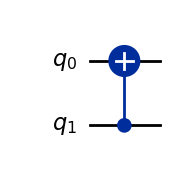

In [6]:
# Registros
quantum_reg_2_qubits = QuantumRegister(2,'q') 

# Circuito
circuit_CNOT = QuantumCircuit(quantum_reg_2_qubits)#, classic_reg_2_bits)
# Añadimos la CNOT
circuit_CNOT.cx(1,0) #(control, target)
circuit_CNOT.draw('mpl',style="iqp")


<IPython.core.display.Latex object>

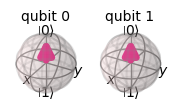

<IPython.core.display.Latex object>

In [7]:
# Simulación de vector de estado
s, c,rs = my_get_circuit_state(circuit_CNOT, shots=1)

# Simulación de matriz unitaria
u, ru = my_get_circuit_unitary(circuit_CNOT)

my_display_state_vector(s,2)

matrix_CNOT = u
array_to_latex(matrix_CNOT, prefix="\\text{CNOT = }\n")

<a id='sec_Notebooks_Circ_multiqubit_1.2'></a>
### Con el control arriba

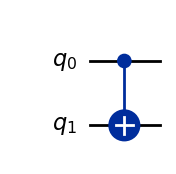

In [8]:
# Circuito
circuit_CNOT_2 = QuantumCircuit(quantum_reg_2_qubits)#, classic_reg_2_bits)
# Añadimos la CNOT
circuit_CNOT_2.cx(0,1) #(control, target)
circuit_CNOT_2.draw('mpl', style="iqp")

<IPython.core.display.Latex object>

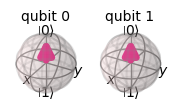

<IPython.core.display.Latex object>

In [9]:
# Simulación de vector de estado
s, c,rs = my_get_circuit_state(circuit_CNOT_2, shots=1)

# Simulación de matriz unitaria
u, ru = my_get_circuit_unitary(circuit_CNOT_2)

my_display_state_vector(s,2)

matrix_CNOT_2 = u
array_to_latex(matrix_CNOT_2, prefix="\\text{CNOT = }\n")

In [10]:
# Registro cuántico
quantum_reg_2_qubits = QuantumRegister(2, 'q') 

# Registro clásico, para medir
classic_reg_2_bits = ClassicalRegister(2, 'c') 

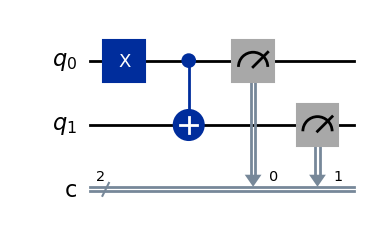

In [11]:
circuit_CNOT_3 = QuantumCircuit(quantum_reg_2_qubits, classic_reg_2_bits)

#################################
# Jugar a comentar y descomentar:
circuit_CNOT_3.x(0)
#circuit_CNOT_3.x(1)
#################################

circuit_CNOT_3.cx(0,1)
circuit_CNOT_3.measure(quantum_reg_2_qubits, classic_reg_2_bits)
circuit_CNOT_3.draw('mpl', style="iqp")

<IPython.core.display.Latex object>

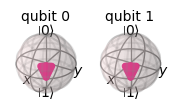

{'11': 1000}

In [12]:
# Simulación de vector de estado
# Utilizar múltiples shots ya que hay medidores
s, c, rs = my_get_circuit_state(circuit_CNOT_3, 1000)

# La simulación unitaria no tiene mucho sentido en
# esta prueba, ya que hemos puesto medidores

my_display_state_vector(s, inches=2)

counts_CNOT_3 = c
counts_CNOT_3

<a id='sec_Notebooks_Circ_multiqubit_2'></a>
## Entrelazamiento: Crear estados entrelazados con la CNOT y la $H$   

Cuando aplicamos una puerta $H$ sobre un qúbit ponemos este qúbit en una superposisción de $| 0 \rangle$ y $| 1 \rangle$:
$$
H | 0 \rangle = \frac{1}{2} \left( | 0 \rangle + | 1 \rangle \right) 
$$

Si ahora pasamos este estado como **controlador** de una puerta CNOT, podemos generar un estado entrelazado. Veamos

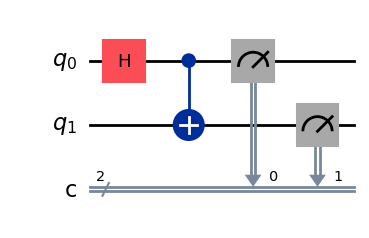

In [13]:
circuit_CNOT_H = QuantumCircuit(quantum_reg_2_qubits, classic_reg_2_bits)
circuit_CNOT_H.h(0)
circuit_CNOT_H.cx(0,1)
circuit_CNOT_H.measure(quantum_reg_2_qubits, classic_reg_2_bits)
circuit_CNOT_H.draw('mpl', style="iqp")

{'00': 2529, '11': 2471}

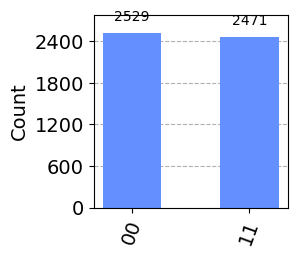

In [14]:
# Simulemos y veamos el histograma

# Utilizar múltiples shots ya que hay medidores
s, c, rs = my_get_circuit_state(circuit_CNOT_H, shots=5000)

state_CNOT_H = s
counts_CNOT_H = c

display(counts_CNOT_H)
display(plot_histogram(counts_CNOT_H, figsize=(2.5,2.5)))

<IPython.core.display.Latex object>

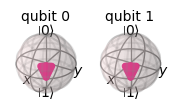

In [15]:
my_display_state_vector(state_CNOT_H, inches=2)

<div style="background-color:#c8e6c9">
<hr>
<b>Ejercicio:</b>
¿Por qué la función que muestra el estado,<tt> my_display_state_vector()</tt>, ha mostrado un estado que no es el entrelazado, para la salida del circuito entrelazador anterior?
<hr>
</div>

Podemos genera otros estados estados entrelazados diferentes:

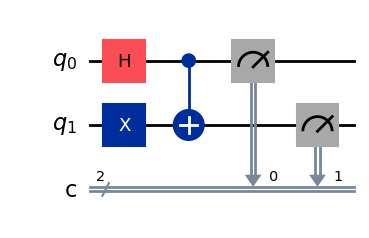

In [16]:
circuit_CNOT_HX = QuantumCircuit(quantum_reg_2_qubits, classic_reg_2_bits)
circuit_CNOT_HX.h(0)
circuit_CNOT_HX.x(1)
circuit_CNOT_HX.cx(0,1)
circuit_CNOT_HX.measure(quantum_reg_2_qubits, classic_reg_2_bits)
circuit_CNOT_HX.draw('mpl', style="iqp")

{'10': 2462, '01': 2538}

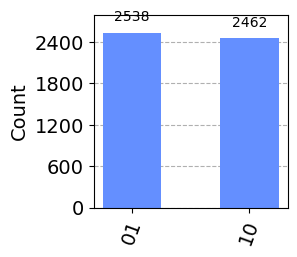

In [17]:
# Simulemos y veamos el histograma

# Simulación de vector de estado
# Utilizar múltiples shots ya que hay medidores
s, c, rs = my_get_circuit_state(circuit_CNOT_HX, shots=5000)

counts_CNOT_HX = c
display(counts_CNOT_HX)
display(plot_histogram(counts_CNOT_HX, figsize=(2.5,2.5)))

<a id='sec_Notebooks_Circ_multiqubit_3'></a>
## Puerta Swap   

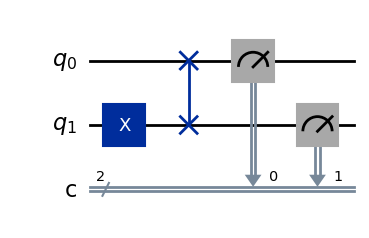

In [18]:
circuit_SWAP = QuantumCircuit(quantum_reg_2_qubits, classic_reg_2_bits)
circuit_SWAP.x(1)
circuit_SWAP.swap(0,1)
circuit_SWAP.measure(quantum_reg_2_qubits, classic_reg_2_bits)
circuit_SWAP.draw('mpl',style="iqp")

{'01': 5000}

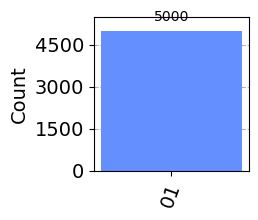

In [19]:
# Simulemos y veamos el histograma

# Simulación de vector de estado
# Utilizar múltiples shots ya que hay medidores
s, c, rs = my_get_circuit_state(circuit_SWAP, shots=5000)

counts_SWAP = c
display(counts_SWAP)
display(plot_histogram(counts_SWAP, figsize=(2,2)))

<a id='sec_Notebooks_Circ_multiqubit_4'></a>
## Puerta CSWAP   

En este ejemplo también vemos que no es necesario que haya los mismos qúbits en registro cuántico que en el clásico. Además, si queremos podemos medir solo unos cuantos qúbit, no todo

In [20]:
# Registro cuántico de 3 qubits
quantum_reg_3_qubits = QuantumRegister(3, 'q') 
# Registro clásico de 2 qubits
classic_reg_2_bits = ClassicalRegister(2, 'cl') 

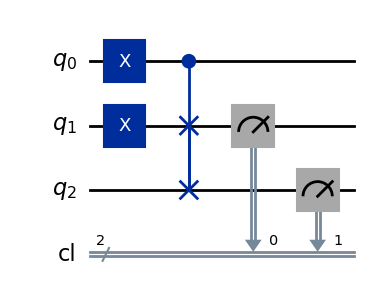

In [21]:
circuit_CSWAP = QuantumCircuit(quantum_reg_3_qubits, classic_reg_2_bits)

#################################
# Jugar a comentar y descomentar:
circuit_CSWAP.x(0)
circuit_CSWAP.x(1)
#################################

circuit_CSWAP.cswap(0,1,2)
circuit_CSWAP.measure(quantum_reg_3_qubits[1:], classic_reg_2_bits)
circuit_CSWAP.draw('mpl',style="iqp")

{'10': 5000}

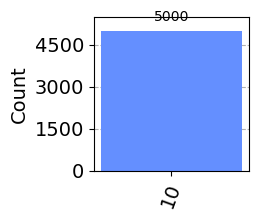

In [22]:
# Simulemos y veamos el histograma

# Simulación de vector de estado
# Utilizar múltiples shots ya que hay medidores
s, c, rs = my_get_circuit_state(circuit_CSWAP, shots=5000)

counts_CSWAP = c
display(counts_CSWAP)
display(plot_histogram(counts_CSWAP, figsize=(2,2)))

<a id='sec_Notebooks_Circ_multiqubit_5'></a>
## CCNOT o Toffoli   

In [23]:
# Registro cuántico de 3 qubits
quantum_reg_3_qubits = QuantumRegister(3, 'q') 
# Registro clásico de 3 qubits
classic_reg_3_bits = ClassicalRegister(3, 'cl') 

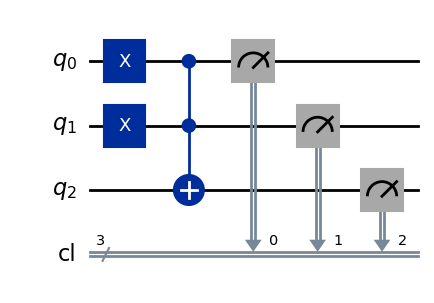

In [24]:
circuit_tof = QuantumCircuit(quantum_reg_3_qubits, classic_reg_3_bits)

#################################
# Jugar a comentar y descomentar una o varias lias:
circuit_tof.x(0)
circuit_tof.x(1)
#################################

circuit_tof.ccx(0,1,2) # Esto es la puerta de TOFFOLI
circuit_tof.measure(quantum_reg_3_qubits, classic_reg_3_bits)
circuit_tof.draw('mpl', style="iqp")

{'111': 5000}

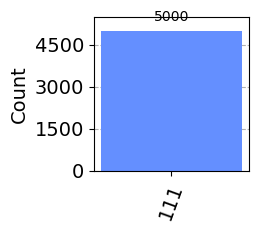

In [25]:
# Simulemos y veamos el histograma

# Simulación de vector de estado
# Utilizar múltiples shots ya que hay medidores
s, c, rs = my_get_circuit_state(circuit_tof, shots=5000)

counts_tof = c
display(counts_tof)
display(plot_histogram(counts_tof, figsize=(2,2)))

<a id='sec_Notebooks_Circ_multiqubit_6'></a>
## Puerta MCX (multicontrolada X)  

In [26]:
# Registros cuánticos
control_reg = QuantumRegister(4, 'q') 
target_qubit = QuantumRegister(1, 'y')

# Registro clásico
classic_reg_1_bits = ClassicalRegister(1, 'cl') 

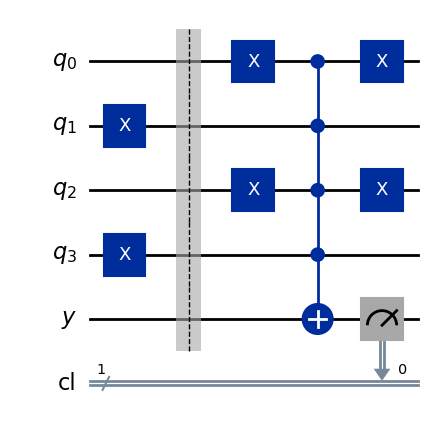

In [27]:
circuit_mcx = QuantumCircuit(control_reg, target_qubit, classic_reg_1_bits)

#################################
# Jugar a comentar y descomentar una o varias lias:
# Inicializacion

#circuit_mcx.x(control_reg[0])
circuit_mcx.x(control_reg[1])
#circuit_mcx.x(control_reg[2])
circuit_mcx.x(control_reg[3])
#################################

circuit_mcx.barrier()

#################################
# Jugar a comentar y descomentar una o varias lias:
# Respetar que en un mismo qubit debe de haber o 
# ninguna X o una antes y otra despues de la mcx

circuit_mcx.x(control_reg[0])
#circuit_mcx.x(control_reg[1])
circuit_mcx.x(control_reg[2])
#circuit_mcx.x(control_reg[3])
#################################

circuit_mcx.mcx(control_reg, target_qubit)

#################################
# Jugar a comentar y descomentar una o varias lias:
# Respetar que en un mismo qubit debe de haber o 
# ninguna X o una antes y otra despues de la mcx

circuit_mcx.x(control_reg[0])
#circuit_mcx.x(control_reg[1])
circuit_mcx.x(control_reg[2])
#circuit_mcx.x(control_reg[3])
#################################

circuit_mcx.measure(target_qubit, classic_reg_1_bits)
circuit_mcx.draw('mpl', style="iqp")

{'1': 5000}

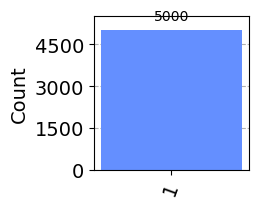

In [28]:
# Simulemos y veamos el histograma

# Simulación de vector de estado
# Utilizar múltiples shots ya que hay medidores
s, c, rs = my_get_circuit_state(circuit_mcx, shots=5000)

counts_mcx = c
display(counts_mcx)
display(plot_histogram(counts_mcx, figsize=(2,2)))

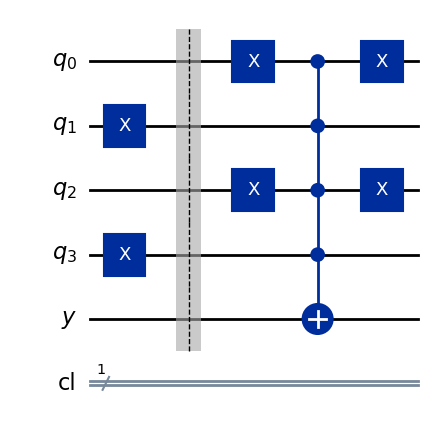

<IPython.core.display.Latex object>

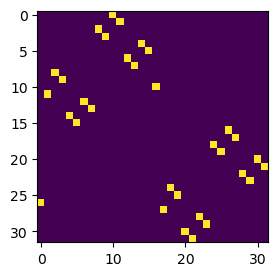

In [29]:
# Vamos a calcular la matriz de este último circuito 

# Pero antes vamos a eliminar el medidor, para ello
# haremos una copia del circuito y recorreremos todas
# sus instrucciones, haciendo una lista de aquellas que
# tengan por nombre 'measure'
circuit_mcx_nomeasure = circuit_mcx.copy()
iidx = 0 # instruction index
lm = []
for g in circuit_mcx_nomeasure.data:
    if g.operation.name == 'measure':
        lm.append(iidx)
    iidx += 1

# Esta es la lista de medidores, vamos a quitarlos
# del circuito con QuantumCircuit.pop()
for iidx in lm:
    circuit_mcx_nomeasure.data.pop(iidx)

# El circuito resultante no debe tener medidores
display(circuit_mcx_nomeasure.draw('mpl', style="iqp"))

# Veamos su matriz unitaria
u, r = my_get_circuit_unitary(circuit_mcx_nomeasure)

matrix_circuit_mcx = u

# Al mostrar la matriz nos saldrá truncada porque es
# muy grande
display(array_to_latex(matrix_circuit_mcx, prefix="\\text{MCX_circuit = }\n"))

# Como esta matriz es muy grande, vamos a representar
# como imagen aquellso elementos con valores no nulos
plt.figure(figsize=(3,3))
plt.imshow(np.abs(matrix_circuit_mcx.data))
plt.show()

In [30]:
import qiskit
from qiskit_aer import AerSimulator
import qiskit.tools.jupyter
%qiskit_version_table